# Cuda setup
Check if cuda is available.

In [102]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [103]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files

Use matplotlib to display graphs and visualizations.

Use torch to create and train a RNN model.

In [104]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

In [105]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN.ipynb
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS
AAPL_intraday.csv
AAPL_intraday1.csv
AMD_intraday.csv
AMD_intraday1.csv
first_try.ipynb
model_trained.pt
README.md
RNN.ipynb


# Helper functions
StockDataset class to hold pytorch data

In [106]:
training_percentage = 6
valid_percentage = 2
testing_percentage = 2
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target
        
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.output, self.hidden = self.rnn1(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction.squeeze(-1)

# get_yahoo_stock_data(name, interval="5m", period="7d")

unction that calls yfinance to get stock data from a defined time period

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [107]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

# get_alpaca_stock_data(name, interval="15", months="6") 

function calls alpaca api to get stock data for a defined time period starting from June 1st 2021

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [108]:
# Generate stock price data from alpaca
def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

# plot_loss(training_loss_array, validation_loss_array, epochs)

Creates a matplotlib plot of the training and validation loss

@params training_loss_array: Array of training loss values

@params validation_loss_array: Array of validation loss values

@params epochs: Number of epochs

In [109]:
# Creates a matplotlib plot of the training and validation loss
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# Display relevant information for formatting purposes

In [110]:
class RNN_initializer:
    #
    def __init__(self, retrieve, name, recomp, nval, ival, pval, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2
        if(retrieve == True):
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name
        self.df=pd.read_csv(name + "_intraday1.csv")
        self.show_df_info()
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
            self.axis_labels = self.df['Price'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[1:]
            self.axis_labels = self.df['Price'].to_list()[1:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"
        self.price_inputs = [float(x) for x in price]
        sequence_length = 4
        #Training sets
        self.train_seq = []
        self.train_tar = []
        #Validation sets
        self.valid_seq = []
        self.valid_tar = []
        #Testing sets
        self.test_seq = []
        self.test_tar = []
        #choose a selected time range
        #NOTE
        train_range = (len(self.price_inputs)//10 * training_percentage)
        print(len(self.price_inputs))
        print(train_range)
        valid_range_beg = train_range
        valid_range_end = train_range + (len(self.price_inputs)//10 * valid_percentage)
        print(valid_range_end)
        test_range_beg = valid_range_end
        test_range_end = valid_range_end + (len(self.price_inputs)//10 * testing_percentage)
        print(test_range_end)
        #generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = self.price_inputs[i:i+sequence_length]
            self.train_seq.append(seq)
            temp = self.price_inputs[i+sequence_length]
            self.train_tar.append(temp)
        for j in range(valid_range_beg, valid_range_end-sequence_length):
            seq = self.price_inputs[j:j+sequence_length]
            self.valid_seq.append(seq)
            temp = self.price_inputs[j+sequence_length]
            self.valid_tar.append(temp)
        for k in range(test_range_beg, test_range_end-sequence_length):
            seq = self.price_inputs[k:k+sequence_length]
            self.test_seq.append(seq)
            temp = self.price_inputs[k+sequence_length]
            self.test_tar.append(temp)
        train_data = StockDataset(self.train_seq, self.train_tar)
        valid_data = StockDataset(self.valid_seq, self.valid_tar)
        test_data = StockDataset(self.test_seq, self.test_tar)
        
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        self.valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1;
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + str(len(self.df)))
        
    def trainAndTest(self):
        #RNN model
        self.rnn1 = RNN()
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            self.rnn1.cuda()
        #use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # specify optimizer
        optimizer = torch.optim.Adam(self.rnn1.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        # Learning rate scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        valid_loss_min = np.inf
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            self.rnn1.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_train = error(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")

            scheduler.step(train_loss)  # Update learning rate

    
            ######################    
            # validate the model #
            ######################
            self.rnn1.eval()
            for batch_idx, (data, target) in enumerate(self.valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.rnn1(data)
                # calculate the batch loss
                loss_valid = error(output, target)
                # perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(self.rnn1.state_dict(), "rnn1.pth")
            # calculate average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            valid_loss = valid_loss/len(self.valid_loader.dataset)
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and (epoch+1) % 10 == 0:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(self.rnn1.state_dict(), 'model_trained.pt')
                valid_loss_min = valid_loss

            if (epoch+1) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item():.6f}, Validation Loss: {loss_valid.item():.6f}")
                training_loss_array.append(int(loss_train.item()))
                validation_loss_array.append(int(loss_valid.item()))
        return min_loss
        


In [111]:
#Stock variables used when collecting stock data
#Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"

#Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="8" #months
    epochs = 100
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

Row count: 10452
10451
6270
8360
10450


-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 Time period:  8
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 1784.275175).  Saving model ...
Epoch 10/100, Training Loss: 528.994629, Validation Loss: 843.930847
Validation loss decreased (1784.275175 --> 1729.230427).  Saving model ...
Epoch 20/100, Training Loss: 496.015930, Validation Loss: 804.700684
Epoch 30/100, Training Loss: 611.355896, Validation Loss: 949.777466
Epoch 40/100, Training Loss: 615.557312, Validation Loss: 953.140076
Epoch 50/100, Training Loss: 548.579590, Validation Loss: 870.543945
Validation loss decreased (1729.230427 --> 1705.675939).  Saving model ...
Epoch 60/100

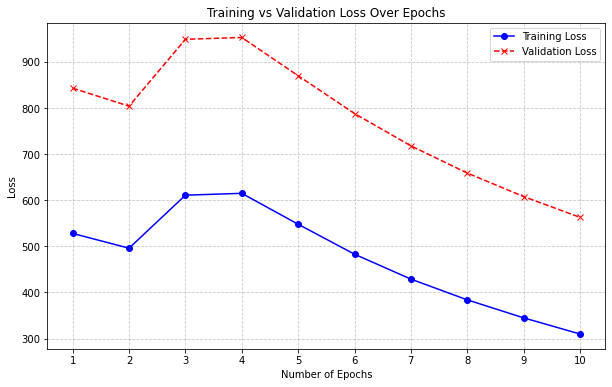



-------------------------------------------------------------------------------
Learning rate:  0.0001    Loop:  1
AMD Time interval  15 Time period:  8
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 8516.262015).  Saving model ...
Epoch 10/100, Training Loss: 5459.944824, Validation Loss: 6397.226562
Validation loss decreased (8516.262015 --> 3312.611640).  Saving model ...
Epoch 20/100, Training Loss: 1498.968262, Validation Loss: 2007.606323
Validation loss decreased (3312.611640 --> 1990.456798).  Saving model ...
Epoch 30/100, Training Loss: 646.549927, Validation Loss: 993.101501
Validation loss decreased (1990.456798 --> 1919.247770).  Saving model ...
Epoch 40/100, Training Loss: 604.832214, Validation Loss: 941.211426
Epoch 50/100, Training Loss: 620.705994, 

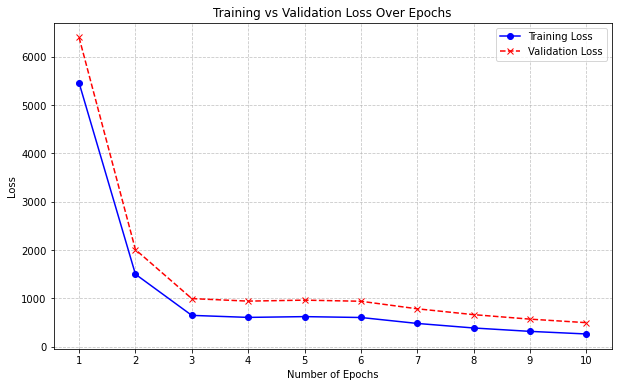



-------------------------------------------------------------------------------
Learning rate:  5e-05    Loop:  1
AMD Time interval  15 Time period:  8
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 12890.503384).  Saving model ...
Epoch 10/100, Training Loss: 9077.359375, Validation Loss: 10276.486328
Validation loss decreased (12890.503384 --> 8292.724657).  Saving model ...
Epoch 20/100, Training Loss: 5278.905762, Validation Loss: 6202.130371
Validation loss decreased (8292.724657 --> 4939.461359).  Saving model ...
Epoch 30/100, Training Loss: 2667.940186, Validation Loss: 3334.937500
Validation loss decreased (4939.461359 --> 2873.718003).  Saving model ...
Epoch 40/100, Training Loss: 1202.291016, Validation Loss: 1662.140503
Validation loss decreased (2873.718

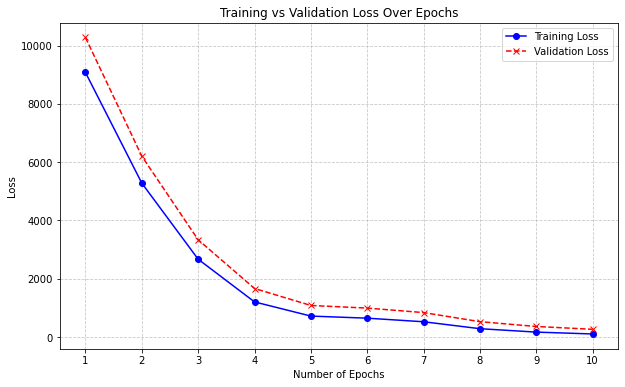



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 Time period:  8
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 17608.873410).  Saving model ...
Epoch 10/100, Training Loss: 13114.237305, Validation Loss: 14549.423828
Validation loss decreased (17608.873410 --> 16315.698422).  Saving model ...
Epoch 20/100, Training Loss: 11997.306641, Validation Loss: 13371.635742
Validation loss decreased (16315.698422 --> 15084.204047).  Saving model ...
Epoch 30/100, Training Loss: 10940.301758, Validation Loss: 12254.370117
Validation loss decreased (15084.204047 --> 13904.834807).  Saving model ...
Epoch 40/100, Training Loss: 9934.911133, Validation Loss: 11188.893555
Validation loss decrease

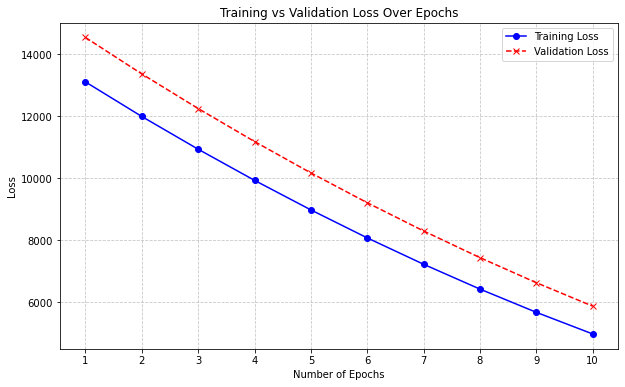



Best learning rate:  0.0005    Loss:  tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  0.0001    Loss:  tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


In [112]:
#test various learning rates
#learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
best_lr_in_loop = np.inf
repeated_loops_per_lr = 1
rnnControl = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                             batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=0.001, lr_scheduler_rate=lr_scheduler_rate,
                             beta1=beta1, beta2=beta2)
bestRNN = [rnnControl,None]
bestRNN_in_loop = rnnControl
for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")
    
    for i in range(repeated_loops_per_lr):
        rnn1 = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        #returns
        training_loss_array = []
        validation_loss_array = []
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss
            bestRNN_in_loop = rnn1
    #if found best lr, remove worst lr from list
    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
        bestRNN[1] = bestRNN[0]
        bestRNN[0] = bestRNN_in_loop
        #if 
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]
        bestRNN[1] = bestRNN_in_loop
    best_lr_in_loop = np.inf

    plot_loss(training_loss_array, validation_loss_array, epochs)

print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])





-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  8 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 1781.327885).  Saving model ...
Epoch 10/100, Training Loss: 527.347961, Validation Loss: 841.822998
Validation loss decreased (1781.327885 --> 1774.392434).  Saving model ...
Epoch 20/100, Training Loss: 521.348145, Validation Loss: 836.867432
Epoch 30/100, Training Loss: 617.669373, Validation Loss: 958.231323
Epoch 40/100, Training Loss: 629.619507, Validation Loss: 970.164734
Epoch 50/100, Training Loss: 562.646362, Validation Loss: 887.757812
Validation loss decreased (1774.392434 --> 1725.702957).  Saving model ...
Epoch 60/100, Training Loss: 495.245911,

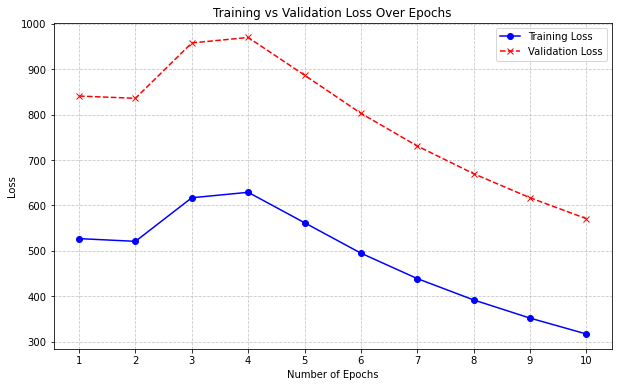



-------------------------------------------------------------------------------
Learning rate:  0.00046    Loop:  1
AMD Time interval  15 min Time period:  8 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 1815.007761).  Saving model ...
Epoch 10/100, Training Loss: 546.229919, Validation Loss: 865.947937
Validation loss decreased (1815.007761 --> 1745.332435).  Saving model ...
Epoch 20/100, Training Loss: 504.989258, Validation Loss: 816.148560
Epoch 30/100, Training Loss: 581.240601, Validation Loss: 912.119568
Validation loss decreased (1745.332435 --> 1447.747730).  Saving model ...
Epoch 40/100, Training Loss: 346.139008, Validation Loss: 609.208679
Validation loss decreased (1447.747730 --> 1130.540543).  Saving model ...
Epoch 50/100, Training Loss: 194.

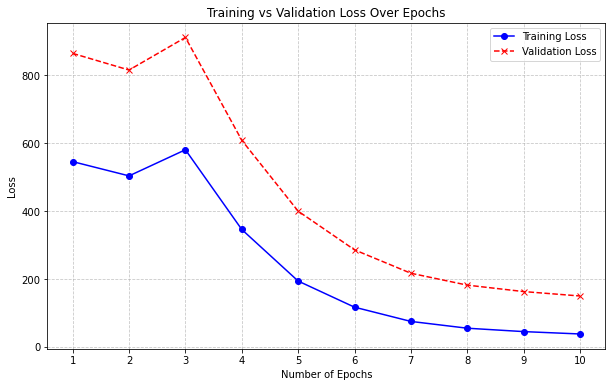



-------------------------------------------------------------------------------
Learning rate:  0.00042    Loop:  1
AMD Time interval  15 min Time period:  8 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 1857.822765).  Saving model ...
Epoch 10/100, Training Loss: 570.506104, Validation Loss: 896.753296
Validation loss decreased (1857.822765 --> 1722.397453).  Saving model ...
Epoch 20/100, Training Loss: 494.690491, Validation Loss: 799.850037
Epoch 30/100, Training Loss: 565.942627, Validation Loss: 892.941162
Validation loss decreased (1722.397453 --> 1410.647494).  Saving model ...
Epoch 40/100, Training Loss: 327.046570, Validation Loss: 583.879150
Validation loss decreased (1410.647494 --> 1131.523375).  Saving model ...
Epoch 50/100, Training Loss: 194.

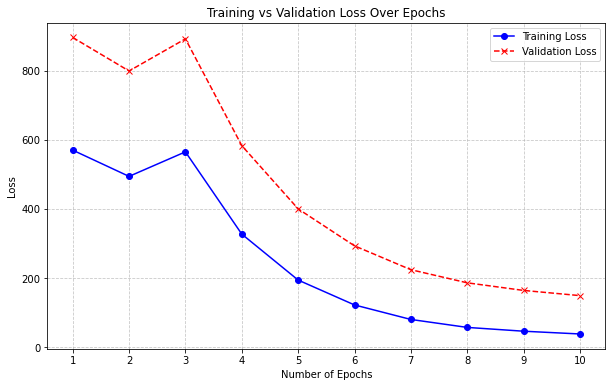



-------------------------------------------------------------------------------
Learning rate:  0.00038    Loop:  1
AMD Time interval  15 min Time period:  8 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Row count: 10452
10451
6270
8360
10450
Validation loss decreased (inf --> 1927.175108).  Saving model ...
Epoch 10/100, Training Loss: 610.443054, Validation Loss: 946.964600
Validation loss decreased (1927.175108 --> 1757.389368).  Saving model ...
Epoch 20/100, Training Loss: 514.074829, Validation Loss: 824.735718
Epoch 30/100, Training Loss: 603.411743, Validation Loss: 939.964844
Validation loss decreased (1757.389368 --> 1553.135025).  Saving model ...
Epoch 40/100, Training Loss: 401.108551, Validation Loss: 681.612366
Validation loss decreased (1553.135025 --> 1213.587139).  Saving model ...
Epoch 50/100, Training Loss: 231.

In [ ]:
learning_rate_list = []
difference_of_lr = best_lr[0][1] - best_lr[1][1]
number_of_increments = 10
increment = difference_of_lr / number_of_increments

for i in range(number_of_increments):
    learning_rate_list.append(best_lr[0][1] - increment * i)

for lr in learning_rate_list:
    print("\n\n-------------------------------------------------------------------------------")
    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
    print("Learning rate scheduler rate: ", lr_scheduler_rate)
    print("Beta1: ", beta1, "Beta2: ", beta2)
    print("-------------------------------------------------------------------------------")

    
    
    for i in range(repeated_loops_per_lr):
        training_loss_array = []
        validation_loss_array = []
        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        loss = rnn1.trainAndTest()
        if best_lr_in_loop > loss:
            best_lr_in_loop = loss

    if best_lr_in_loop < best_lr[0][0]:
        best_lr[1] = best_lr[0]
        best_lr[0] = [best_lr_in_loop, lr]
    elif best_lr_in_loop < best_lr[1][0]:
        best_lr[1] = [best_lr_in_loop, lr]

    best_lr_in_loop = np.inf


    plot_loss(training_loss_array, validation_loss_array, epochs)


print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

In [ ]:
#if stock_data_source == "yahoo":
    #Stock variables when using yahoo finance api
#    stock_name = "AMD"
#    stock_interval="5m"
#    stock_period="7d"
#    epochs = 100
#    lr_scheduler_rate = 0.8
#    beta1 = 0.9
#    beta2 = 0.999

#Stock variables when using alpaca api
#if stock_data_source == "alpaca":
#    stock_name = "AMD"
#    stock_interval="15"
#    stock_period="24" #months
#    epochs = 200
#    lr_scheduler_rate = 0.1
#    beta1 = 0.95
#    beta2 = 0.999

#batch_size = 16
#num_workers = 0

In [ ]:

#test previous god perfoming rates learning rates
#learning_rate_list = [0.00018, 0.00016, 0.00014, 0.00012]
#best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
#best_lr_in_loop = np.inf
#repeated_loops_per_lr = 3

#for lr in learning_rate_list:
#    print("\n\n-------------------------------------------------------------------------------")
#    print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
#    print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
#    print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
#    print("Learning rate scheduler rate: ", lr_scheduler_rate)
#    print("Beta1: ", beta1, "Beta2: ", beta2)
#    print("-------------------------------------------------------------------------------")
    
#    for i in range(repeated_loops_per_lr):
#        training_loss_array = []
#        validation_loss_array = []
#        rnn1 = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
#        loss = rnn1.trainAndTest()
#        if best_lr_in_loop > loss:
#            best_lr_in_loop = loss

#    if best_lr_in_loop < best_lr[0][0]:
#        best_lr[1] = best_lr[0]
#        best_lr[0] = [best_lr_in_loop, lr]
#    elif best_lr_in_loop < best_lr[1][0]:
#        best_lr[1] = [best_lr_in_loop, lr]

#    plot_loss(training_loss_array, validation_loss_array, epochs)

In [ ]:
#output,hidden = rnn1(price_tensor)
#print(output.shape)  # (1, 1, 128)
#print(hidden.shape)  # (2, 1, 128)
  # Predict 1 value from hidden_size=128

#prediction = fc(output[:, -1, :])  # Take output at last time step
#print(prediction)

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [ ]:
#error = nn.MSELoss()
#optimizer = torch.optim.Adam(prediction.parameters(), lr=0.001)

#epochs = 50
#for epoch in range(epochs):
#    rnn1.train()
#    fc.train()
    
#      output,hidden = rnn1(price_tensor)
#    prediction = fc(output[:, -1, :])
#    loss = error(prediction, y_tensor)
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

#    if (epoch+1) % 10 == 0:
#        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

In [ ]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()

bestRNN[0].rnn1.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(bestRNN[0].test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = bestRNN[0].rnn1(data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (test_loss,
    value_correct, len(bestRNN[0].test_loader.dataset)))